#PRACTICA 04 PARTE 1 MINERIA DE DATOS
---
```
Docente    : Carlos Fernando Montoya Cubas
Alumno     : Cesar Rodrigo Ttito Quilca
Codigo     : 140998
Proposito  : Realizar 5 algoritmos de pre procesamiento de datos o paralelizados
```
---



In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     |████████████████████████████████| 204.2 MB 28 kB/s 
     |████████████████████████████████| 198 kB 62.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612246 sha256=f391e3aac40bdadc39c3ef385e7edcc30cd8e7cf5e02e452a2d1eed249a364d3
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

##Primer Ejercicio






### **Distancia de Minkowski**
Como sabemos la distancia de minkowski es la Distancia entre dos vectores numéricos 

*Distancia Minkowsi*


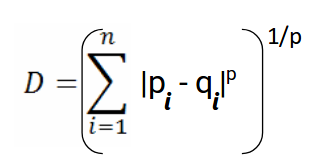

El parámetro p de la métrica de distancia de Minkowski de **`Pyspark`** representa el orden de la norma. Cuando el orden (p) es 1, representará la Distancia de Manhattan y cuando el orden en la fórmula anterior es 2, representará la Distancia euclidiana.

Cuando nuestros objetos están representados en el espacio Minkowski, medimos la similitud entre ellos a través de la *p-Norma* definida por:

$$d(x,y,p) = (\sum_{i=1}^{n}{|x_i - y_i|^p})^{1/p}$$      $$p≥1$$

la norma $p$ siempre puede tomar cualquier valor:


$$d(x,y,p) = (\sum_{i=1}^{n}{|x_i - y_i|^p})$$

$$d(x,y,\infty) = \max(|x_1 - y_1|,|x_2 - y_2|, ..., |x_n - y_n|)^p$$

$$d(x,y,\infty) = \min(|x_1 - y_1|,|x_2 - y_2|, ..., |x_n - y_n|)^p$$

In [4]:
import numpy as np

# Creemos una función rNorm que toma como parámetro y devuelve una función que calcula el pNorm
def pNorm(p):
    def Dist(x,y):
        return np.power(np.power(np.abs(x-y),p).sum(),1/float(p))
    return Dist
# Creemos un RDD con valores numéricos.
np.random.seed(50)
num_p = sc.parallelize(enumerate(np.random.random(size=(10,100))))

In [5]:
num_p

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:262

*Aqui mostramos la formula del minkowski tiene un parecido a la formula euclidian lo que diferencia es su norma ya que el monkwoski puede aceptar valores P y el euclian solo valor 2*


In [10]:
#Formula Minswoski
dat_p = num_p.cartesian(num_p)
dato_p = dat_p.map(lambda x: ((x[0][0],x[1][0]), (x[0][1],x[1][1])))
#minwoski el valor p tendra diferentes valores 
p = 5
#p = 6
# p = 7
Minkow = pNorm(p)
dist = dato_p.map(lambda x: (x[0], Minkow(x[1][0],x[1][1])))
soluc = dist.map(lambda x: x[1])
minv, maxv, meanv = soluc.min(), soluc.max(), soluc.mean()

print('minimo valor minkowski: ',minv)
print('maximo valor minkowski: ',maxv)
print('Media de los valores minkowski: ',meanv)


minimo valor minkowski:  0.0
maximo valor minkowski:  1.444514010466728
Media de los valores minkowski:  1.2070128755149965


## Segundo Ejercicio

### Escalonamiento

Los algoritmos basados en metodos de gradiente tienden a beneficiarse cuando los atributos estan entre $[0,1]$.

$X_{i,j} = \frac{X_{i,j} - max X_j} {max X_j - min_{X_j}}$

In [11]:
import IPython
from pyspark import SparkConf 
from pyspark.context import SparkContext 
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

In [12]:
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [13]:
spark

In [14]:
#Creamos datos
df = spark.createDataFrame([ (1, 'Alex',120,45),
                             (2, 'Paul',200,90),
                             (3, 'Yuger',60,81),
                             (4, 'Kusko',50,50),
                             (5, 'Maldonado',500,55),
                             (6, 'pedro',140,46)
                             ], ["ID", "Nombre","Ahorro","Dia"])

#Mostrar datos iniciales
print("Data :")
df.collect()
df.show(6)

#Coversion a tipo doble
unlist = udf(lambda x: round(float(list(x)[0]),4), DoubleType())

# columnas para el escalonamiento
for i in ["Ahorro","Dia"]:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    # MinMaxScaler
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Escalonado")
    pipeline = Pipeline(stages=[assembler, scaler])
    #Ajuste del pipeline
    df = pipeline.fit(df).transform(df).withColumn(i+"_Escalonado", unlist(i+"_Escalonado")).drop(i+"_Vect")

print("Escalonamiento :")
df.collect()


Data :
+---+---------+------+---+
| ID|   Nombre|Ahorro|Dia|
+---+---------+------+---+
|  1|     Alex|   120| 45|
|  2|     Paul|   200| 90|
|  3|    Yuger|    60| 81|
|  4|    Kusko|    50| 50|
|  5|Maldonado|   500| 55|
|  6|    pedro|   140| 46|
+---+---------+------+---+

Escalonamiento :


[Row(ID=1, Nombre='Alex', Ahorro=120, Dia=45, Ahorro_Escalonado=0.1556, Dia_Escalonado=0.0),
 Row(ID=2, Nombre='Paul', Ahorro=200, Dia=90, Ahorro_Escalonado=0.3333, Dia_Escalonado=1.0),
 Row(ID=3, Nombre='Yuger', Ahorro=60, Dia=81, Ahorro_Escalonado=0.0222, Dia_Escalonado=0.8),
 Row(ID=4, Nombre='Kusko', Ahorro=50, Dia=50, Ahorro_Escalonado=0.0, Dia_Escalonado=0.1111),
 Row(ID=5, Nombre='Maldonado', Ahorro=500, Dia=55, Ahorro_Escalonado=1.0, Dia_Escalonado=0.2222),
 Row(ID=6, Nombre='pedro', Ahorro=140, Dia=46, Ahorro_Escalonado=0.2, Dia_Escalonado=0.0222)]

El valor minimo de la columna *ahorro_escalonado* es 0.0 y el maximo es 0.333, estos estan representados correctamente en el escalonamiento estando entre 0 y 1 respectivamente, de manera similar sucede en la columna *Dia_Escalonado*.

##Tercer Ejercicio


### Normalizacion

In [16]:
import math
#Nomazlizar elementos aleatorios 
def normalizar(x):
    #Vector para normalizar
    listaCuadrada=x.map(lambda xi:xi*xi)
    total=listaCuadrada.sum()
    val=math.sqrt(total)
    #Escalonar vector
    lista= x.map(lambda xi :(xi/val))
    return lista 

Vector = sc.parallelize(range(10,55),4)
VectorEscalonada=normalizar(Vector)
#mostrar resultado
print("normalizacion de numeros aleatorio entre los rangos 10 a 55")
VectorEscalonada.collect()

normalizacion de numeros aleatorio entre los rangos 10 a 55


[0.043165244215452044,
 0.04748176863699725,
 0.05179829305854245,
 0.056114817480087655,
 0.060431341901632865,
 0.06474786632317807,
 0.06906439074472327,
 0.07338091516626848,
 0.07769743958781368,
 0.08201396400935888,
 0.08633048843090409,
 0.09064701285244929,
 0.0949635372739945,
 0.0992800616955397,
 0.1035965861170849,
 0.1079131105386301,
 0.11222963496017531,
 0.11654615938172053,
 0.12086268380326573,
 0.12517920822481093,
 0.12949573264635614,
 0.13381225706790134,
 0.13812878148944654,
 0.14244530591099175,
 0.14676183033253695,
 0.15107835475408216,
 0.15539487917562736,
 0.15971140359717256,
 0.16402792801871777,
 0.16834445244026297,
 0.17266097686180817,
 0.17697750128335338,
 0.18129402570489858,
 0.18561055012644379,
 0.189927074547989,
 0.1942435989695342,
 0.1985601233910794,
 0.2028766478126246,
 0.2071931722341698,
 0.211509696655715,
 0.2158262210772602,
 0.22014274549880541,
 0.22445926992035062,
 0.22877579434189585,
 0.23309231876344105]

## Cuarto Ejercicio

### Binarizacion
Consiste en transformar las cadenas de texto que tienen valores de string (True y False) a valores numericos, 0 para False y 1 para True

In [17]:
import pyspark.sql.functions as F
from functools import reduce

In [18]:
#Creamos el data a usar
df = spark.createDataFrame([ (1, 'Rodrigo',"Maculino","True"),
                             (2, 'Vanesa',"Femenino","False"),
                             (3, 'Cesar',"Maculino","True"),
                             (4, 'Maria',"Femenino","False"),
                             (5, 'Alex',"Maculino","True"),
                             (6, 'Rosmel',"Maculino","True"),
                             (7, 'Juana',"Femenino","False"),
                             (8, 'Luciana',"Femenino","False")
                           ], ["ID", "Nombre","Sexo","Valor String"])

#Mostramos los datos
print("Data :")
df.show()

#Aqui podemos elegir en que columnas aplicar la binarizacion
cols = ['Valor String']

#Aplicar la binarizacion al dataframe spark
df_reduced = reduce(lambda df, c: df.withColumn(c, F.when(df[c] == 'False', 0.0).otherwise(1.0)), cols, df)

#Mostrar columna binarizada
print("Data + Columna binarizada:")
df_reduced.show()

Data :
+---+-------+--------+------------+
| ID| Nombre|    Sexo|Valor String|
+---+-------+--------+------------+
|  1|Rodrigo|Maculino|        True|
|  2| Vanesa|Femenino|       False|
|  3|  Cesar|Maculino|        True|
|  4|  Maria|Femenino|       False|
|  5|   Alex|Maculino|        True|
|  6| Rosmel|Maculino|        True|
|  7|  Juana|Femenino|       False|
|  8|Luciana|Femenino|       False|
+---+-------+--------+------------+

Data + Columna binarizada:
+---+-------+--------+------------+
| ID| Nombre|    Sexo|Valor String|
+---+-------+--------+------------+
|  1|Rodrigo|Maculino|         1.0|
|  2| Vanesa|Femenino|         0.0|
|  3|  Cesar|Maculino|         1.0|
|  4|  Maria|Femenino|         0.0|
|  5|   Alex|Maculino|         1.0|
|  6| Rosmel|Maculino|         1.0|
|  7|  Juana|Femenino|         0.0|
|  8|Luciana|Femenino|         0.0|
+---+-------+--------+------------+



##Quinto Ejercicio

### Distancia Jaccard

La distancia de Jaccard ( $I_J$ ) o coeficiente de Jaccard ( $I_J$ ) mide el grado de similitud entre dos conjuntos, sea cual sea el tipo de elementos.

La formulación es la siguiente:

$$ J(x,y) = \frac{\sum_{i=1}^{n}{x_i == y_i} }{\sum_{i=1}^{n}{\max(x_i, y_i}) } $$

In [19]:
#Calcula la distancia Jaccard entre dos vectores binarios.
#x, y (np.array): Matriz de enteros binarios x and y.
#Returns: J (int): La distancia Jaccard entre x and y.
def Jaccard(x,y):
    return (x==y).sum()/float( np.maximum(x,y).sum())

colores = sc.parallelize(enumerate([['rojo', 'negro', 'azul'],
                             ['rosado', 'negro', 'verde'],
                             ['rosado', 'amarillo', 'azul'],
                             ['rosado', 'negro', 'verde'],
                             ['rojo', 'amarillo', 'verde'],
                            ]))
datos = (colores
             .flatMap(lambda x: [((x[0],xi),1) for xi in x[1]])
             .reduceByKey(lambda x,y: x)
             .map(lambda x: x[0])
             )

dato = dict((v,k) for k,v in datos.collect())
ndato = len(dato)
print(dato, ndato)

{'rojo': 4, 'negro': 3, 'rosado': 3, 'verde': 3, 'azul': 2, 'amarillo': 4} 6


In [20]:
#Binarizar el vector categórico usando un diccionario de key
#atributos (lista): Lista de atributos de un objeto dado

def Bina(atributos,dato):  
    array = np.zeros(len(dato))
    for atr in atributos:
        array[ dato[atr] ] = 1
    return array

# Convierta datosa formato binario usando key  dict
binarizar = colores.map(lambda rec: (rec[0],Bina(rec[1], dato)))
binarizar.collect()

[(0, array([0., 0., 1., 1., 1., 0.])),
 (1, array([0., 0., 0., 1., 0., 0.])),
 (2, array([0., 0., 1., 1., 1., 0.])),
 (3, array([0., 0., 0., 1., 0., 0.])),
 (4, array([0., 0., 0., 1., 1., 0.]))]

In [22]:
# Adquirir dentro de los  PySpark para hallar produto cartesiano 
Binario = binarizar.cartesian(binarizar)
# Aplicar un mapa para transformar nuestro RDD en un RDD de tupla ((id1, id2), (vector1, vector2))
# use el comando take (1) e imprima el resultado para verificar el formato RDD actual
Binario_par = Binario.map(lambda x: ((x[0][0],x[1][0]), (x[0][1],x[1][1])))
#Aplicar un mapa para calcular la distancia de Jaccard entre pares
jacRDD = Binario_par.map(lambda x: (x[0], Jaccard(x[1][0],x[1][1])))
#calcular min, max, mean
statJRDD = jacRDD.map(lambda x: x[1])
Jmin, Jmax, Jmean = statJRDD.min(), statJRDD.max(), statJRDD.mean()

print ("\t\tMin\tMax\tMean")
print ("Jaccard:\t{:.2f}\t{:.2f}\t{:.2f}".format( Jmin, Jmax, Jmean ))



		Min	Max	Mean
Jaccard:	1.33	6.00	2.49


In [23]:
print('distancia jaccard para el modulo binarizar')
statJRDD.collect()

distancia jaccard para el modulo binarizar


[2.0,
 1.3333333333333333,
 1.3333333333333333,
 6.0,
 2.0,
 1.3333333333333333,
 1.6666666666666667,
 1.3333333333333333,
 6.0,
 2.5,
 2.0,
 1.3333333333333333,
 1.3333333333333333,
 1.6666666666666667,
 6.0,
 2.5,
 2.0,
 1.3333333333333333,
 1.6666666666666667,
 1.3333333333333333,
 1.6666666666666667,
 6.0,
 2.5,
 2.5,
 3.0]